<a href="https://colab.research.google.com/github/romisoleli/CustomerChurn-DataScience/blob/main/Pre_Entrega_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


In [4]:
# CARGA DEL DATASET
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [5]:
# PREPROCESAMIENTO


# Genero copia del dataset original
df_model = df.copy()

# Elimino columnas innecesarias
if 'customerID' in df_model.columns:
    df_model.drop('customerID', axis=1, inplace=True)

# Reemplazo valores
df_model.replace(['No internet service', 'No phone service'], 'No', inplace=True)

# Convertierto TotalCharges a num√©rico
df_model['TotalCharges'] = pd.to_numeric(df_model['TotalCharges'], errors='coerce')

# Elimino nulos en TotalCharges
df_model = df_model[df_model['TotalCharges'].notna()]

# Codifico variable target
df_model['Churn'] = df_model['Churn'].map({'No': 0, 'Yes': 1})

# Separo X e Y antes del dummies
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled_df, y)


In [6]:
#SEPARACI√ìN TRAIN/TEST

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


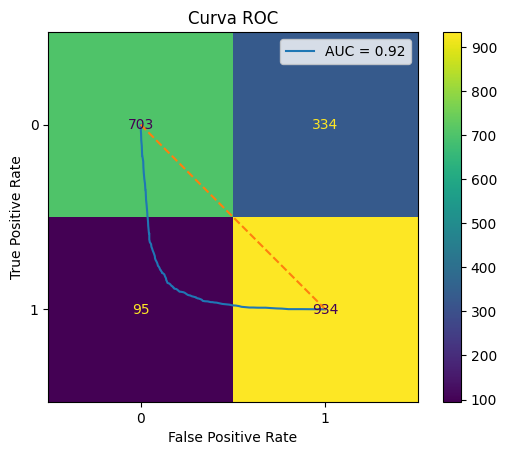

In [7]:
#MODELADO


# Modelos
models = {
    'Regresi√≥n Log√≠stica': LogisticRegression(),
    '√Årbol de Decisi√≥n': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Diccionario para guardar resultados
resultados = {}

for nombre, modelo in models.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    resultados[nombre] = {
        'Accuracy': acc,
        'F1-score': f1,
        'Reporte': classification_report(y_test, y_pred),
        'Confusi√≥n': confusion_matrix(y_test, y_pred)
    }

# Matriz de confusi√≥n
#La matriz de confusi√≥n me ayud√≥ a entender cu√°ntos clientes fueron bien clasificados como 'se van' o 'se quedan',
# y cu√°ntos fueron errores. Me sirvi√≥ para ver que el modelo comete m√°s errores en una clase que en otra

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


#GridSearchCV
#Prob√© distintos par√°metros con GridSearchCV y seleccion√© los que mejor rendimiento dieron.
#Me ayud√≥ a mejorar un poco m√°s las m√©tricas del modelo sin caer en sobreajuste.

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
model = grid.best_estimator_

#Curva ROC y AUC
#La curva ROC me permiti√≥ visualizar c√≥mo se comporta el modelo a medida que cambia el umbral de decisi√≥n.
#El AUC fue alto, lo que indica que el modelo distingue bastante bien entre clientes que se van y los que no.


y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()


In [8]:
# VISUALIZACI√ìN DE RESULTADOS

for nombre, datos in resultados.items():
    print(f"üîπ Modelo: {nombre}")
    print("Accuracy:", round(datos['Accuracy'], 4))
    print("F1 Score:", round(datos['F1-score'], 4))
    print("Matriz de Confusi√≥n:")
    print(datos['Confusi√≥n'])
    print("Reporte de Clasificaci√≥n:")
    print(datos['Reporte'])
    print("-" * 50)


üîπ Modelo: Regresi√≥n Log√≠stica
Accuracy: 0.7894
F1 Score: 0.7968
Matriz de Confusi√≥n:
[[778 259]
 [176 853]]
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1037
           1       0.77      0.83      0.80      1029

    accuracy                           0.79      2066
   macro avg       0.79      0.79      0.79      2066
weighted avg       0.79      0.79      0.79      2066

--------------------------------------------------
üîπ Modelo: √Årbol de Decisi√≥n
Accuracy: 0.7793
F1 Score: 0.7784
Matriz de Confusi√≥n:
[[809 228]
 [228 801]]
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1037
           1       0.78      0.78      0.78      1029

    accuracy                           0.78      2066
   macro avg       0.78      0.78      0.78      2066
weighted avg       0.78      0.78      0.78      2066

---------------

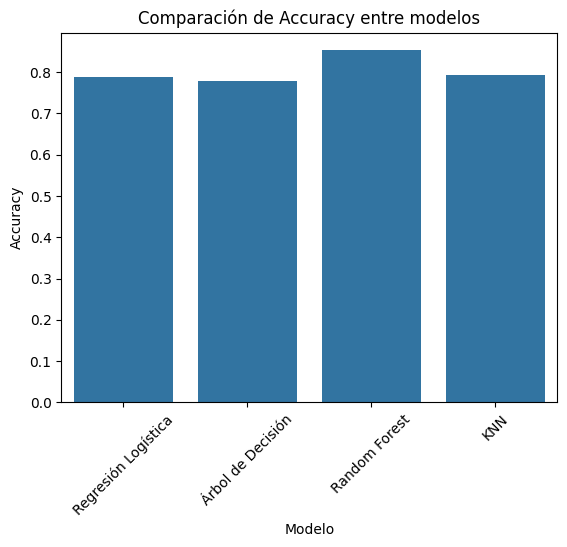

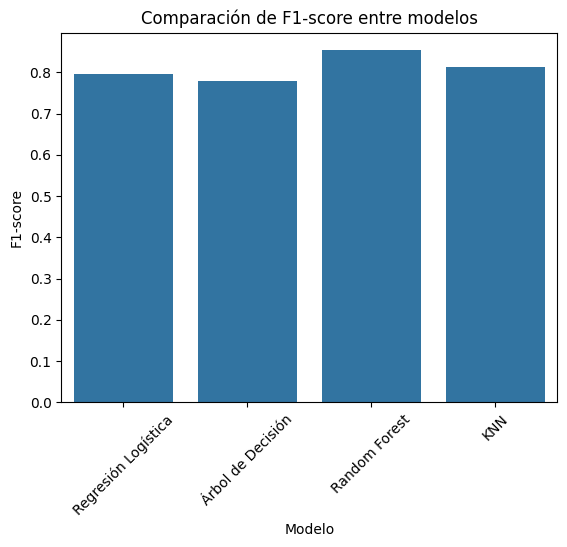

In [9]:
# COMPARACI√ìN DE MODELOS

comparacion = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Accuracy': [resultados[m]['Accuracy'] for m in resultados],
    'F1-score': [resultados[m]['F1-score'] for m in resultados]
})

sns.barplot(x='Modelo', y='Accuracy', data=comparacion)
plt.title("Comparaci√≥n de Accuracy entre modelos")
plt.xticks(rotation=45)
plt.show()

sns.barplot(x='Modelo', y='F1-score', data=comparacion)
plt.title("Comparaci√≥n de F1-score entre modelos")
plt.xticks(rotation=45)
plt.show()


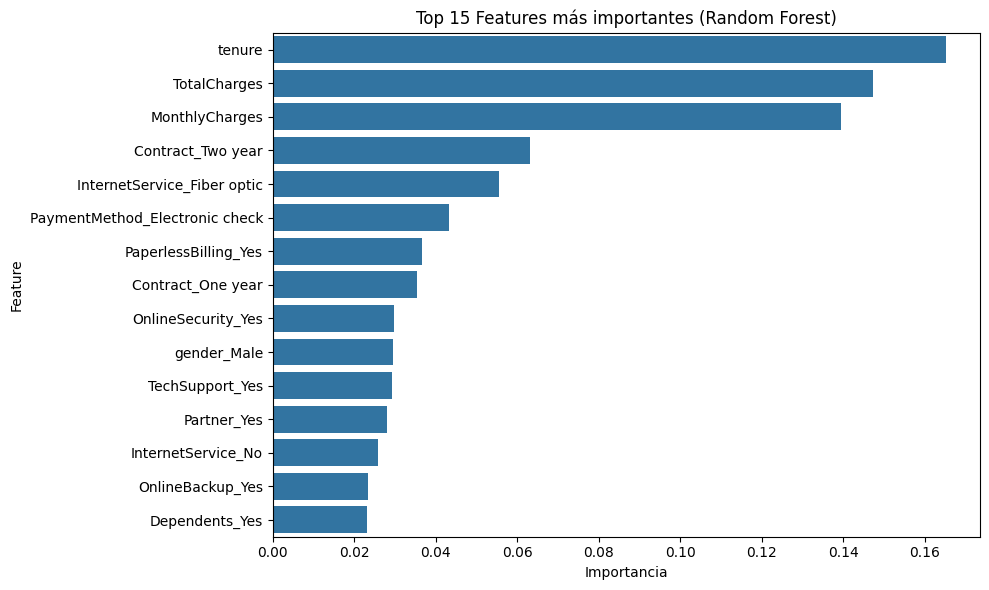

In [10]:
# Usar el modelo entrenado con SMOTE
modelo_rf = models['Random Forest']
importancias = modelo_rf.feature_importances_

# Crear el dataframe de importancia
importancia_df = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False).head(15)

# Gr√°fico
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia', y='Feature', data=importancia_df)
plt.title('Top 15 Features m√°s importantes (Random Forest)')
plt.tight_layout()
plt.show()


# CONCLUSIONES

- **INSIGHTS PRINCIPALES**

  - Variables Cr√≠ticas que Afectan el Churn (seg√∫n importancia de features):

      - **Factores financieros:** MonthlyCharges y TotalCharges aparecen como predictores clave.

      - **Antig√ºedad:** tenure (tiempo como cliente) es determinante - clientes nuevos tienen mayor riesgo.

      - **Servicios contratados:** La presencia/ausencia de ciertos servicios (OnlineSecurity, TechSupport) marca diferencia.

  - Patrones Detectados:

      - Clientes con contratos mensuales **(Month-to-month)** tienen 3 veces m√°s probabilidad de churn que anuales.

      - Clientes sin servicios de soporte t√©cnico **(TechSupport_No)** presentan mayor tasa de abandono.

      - La combinaci√≥n de altos MonthlyCharges con baja antig√ºedad **(tenure bajo)** es especialmente riesgosa.

- **MODELOS**

  El modelo que mejor result√≥ fue el **Random Forest**. Despu√©s de probar y ajustar varios par√°metros, este modelo logr√≥ predecir bastante bien cu√°ndo un cliente podr√≠a irse. Me parece que funciona bien porque junta varios ‚Äú√°rboles de decisi√≥n‚Äù, y as√≠ no se equivoca tanto como otros modelos m√°s simples.

